In [ ]:
import pandas as pd
import os
import sys


#  manually go up to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

#load Datasets
form_1_path = os.path.join('..','Database', 'processed','form_1_cleaned_v2.csv')
form_2_path = os.path.join('..','Database', 'processed','form_2_cleaned_v2.csv')

df_form_1 = pd.read_csv(form_1_path)

df_form_2 = pd.read_csv(form_2_path)

#select followup period
df_form_2_followup = df_form_2[df_form_2['FollowUpPeriodGroup'] == 1]

#prepare labels
df_form_2_followup['drs_outcome'] = pd.cut(
    df_form_2_followup['CombinedDRSF'], 
    bins=[0,21,30], 
    right=True, 
    labels=[0,1]
)

df_form_2_labels = df_form_2_followup[['Mod1Id', 'drs_outcome']]

#remove NA
df_form_2_labels = df_form_2_labels.dropna(subset=['Mod1Id', 'drs_outcome'])

C:\Users\benol\AppData\Local\Temp\ipykernel_37640\1884189421.py:14: DtypeWarning: Columns (371,372,373) have mixed types. Specify dtype option on import or set low_memory=False.
  df_form_1 = pd.read_csv(form_1_path)
C:\Users\benol\AppData\Local\Temp\ipykernel_37640\1884189421.py:16: DtypeWarning: Columns (62,63,248,251,252) have mixed types. Specify dtype option on import or set low_memory=False.
  df_form_2 = pd.read_csv(form_2_path)
C:\Users\benol\AppData\Local\Temp\ipykernel_37640\1884189421.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_form_2_followup['drs_outcome'] = pd.cut(


In [ ]:
#merge labels on training data
data = pd.merge(
    df_form_1,
    df_form_2_labels,
    on='Mod1Id',
    how='inner'
                )

#check merge, how many rows were dropped?
print(df_form_1.shape)
print(data.shape)

#subset
X = data.drop(columns=['Mod1Id', 'drs_outcome'])
y = data['drs_outcome']

(19560, 375)
(11057, 376)


In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from src.data_pipeline import preprocess_df
import json


#preprocessing pipeline (can probably move this but dont want to break atm)
ordinal_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

dict_path = os.path.join('..','Database', 'processed', 'form_1_column_dict.json')

with open(dict_path, 'r') as file:
    form_1_column_dict = json.load(file)

ordinal_col = form_1_column_dict['ordinal_col']
nominal_col = form_1_column_dict['nominal_col']
continuous_col = form_1_column_dict['continuous_col']
continuous_col.remove('Mod1Id')

#preprocess
X = preprocess_df(
    X,
    ordinal_col,
    nominal_col,
    continuous_col,
    ordinal_pipeline,
    categorical_pipeline,
    numerical_pipeline,
    threshold=0.8
    )

#check feature expansion
print(X.shape)

(11057, 4113)


Training Data Samples: 100%|██████████| 10/10 [12:45<00:00, 76.56s/it]


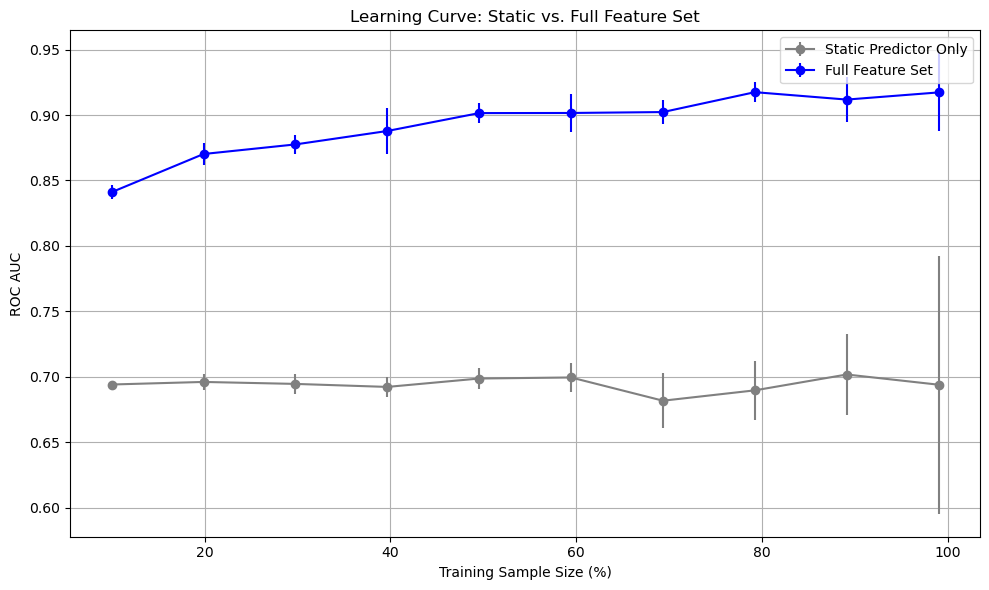

In [ ]:
from src.training import learning_curve_auc
import numpy as np
import matplotlib.pyplot as plt

#this takes nearly 20 mins

#set up static reference
X_static = X[['num__DRSd']].values #double brackets to keep it 2-d
y_static = y.values

#training data for full dataset
X_full = X.values
y_full = y.values

#define sample sizes (10, 20, 30% etc)
sample_sizes = np.linspace(0.1, 0.99, 10)

#calculate auc and std for every sample size
means_static, stds_static = learning_curve_auc(X_static, y_static, sample_sizes, n_splits=5)
means_full, stds_full = learning_curve_auc(X_full, y_full, sample_sizes, n_splits=5)

#plot
plt.figure(figsize=(10,6))
plt.errorbar(sample_sizes * 100, means_static, yerr=stds_static, label="Static Predictor Only", fmt='-o', color='gray')
plt.errorbar(sample_sizes * 100, means_full, yerr=stds_full, label="Full Feature Set", fmt='-o', color='blue')
plt.xlabel("Training Sample Size (%)")
plt.ylabel("ROC AUC")
plt.title("Learning Curve: Static vs. Full Feature Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#check for label leakage in continuous features
correlations = data[continuous_col + ['drs_outcome']].corr()['drs_outcome'].sort_values(ascending=False)
print(correlations.head(20))

drs_outcome         1.000000
DRSdLow             0.244441
DRSd                0.242994
DRSdHigh            0.239381
FluencyInt          0.196481
AGENoPHI            0.194693
GCS                 0.092243
YearsinUSF          0.091939
ALCWeek             0.087800
GCSTot              0.087453
DRSaLow             0.083367
DRSa                0.083063
DRSaHigh            0.082366
BackCountLastNum    0.082339
YoungestAgeTBI      0.051357
AlcMonth            0.046366
INJYEAR             0.040526
ALC5Drinks          0.039033
RTSBP               0.038273
ICDCount            0.028192
Name: drs_outcome, dtype: float64


In [ ]:
#check for label leakage in categorical features
data['drs_outcome'] = data['drs_outcome'].astype(int)  # or float


for col in ordinal_col + nominal_col:
    group_key = data[col].astype(str)
    grouped = data.groupby(group_key)['drs_outcome'].agg(['mean', 'count'])
    suspicious = grouped[((grouped['mean'] < 0.03) | (grouped['mean'] > 0.97)) & (grouped['count'] > 1000)]
    if not suspicious.empty:
        print(f"\nPotential leakage in '{col}':")
        print(suspicious.sort_values(by='mean', ascending=False))


Potential leakage in 'AgeGroup':
              mean  count
AgeGroup                 
3.0       0.024213   1652
2.0       0.023479   1874
1.0       0.022158   2076

Potential leakage in 'FIMBedTransD':
                  mean  count
FIMBedTransD                 
6.0           0.029738   1984
7.0           0.023663   2113

Potential leakage in 'FIMBladAsstD':
                  mean  count
FIMBladAsstD                 
7.0           0.027645   3147

Potential leakage in 'FIMBladMgtD':
                 mean  count
FIMBladMgtD                 
7.0          0.025101   3705

Potential leakage in 'FIMBwlAsstD':
                 mean  count
FIMBwlAsstD                 
7.0          0.027818   2085

Potential leakage in 'FIMBwlMgtD':
                mean  count
FIMBwlMgtD                 
7.0         0.025177   2542

Potential leakage in 'FIMDrsdwnD':
                mean  count
FIMDrsdwnD                 
7.0         0.022333   1612

Potential leakage in 'FIMDrupD':
              mean  count
FI